In [68]:
import jax
import jax.numpy as jnp
import jax.random as jr
import optax

# import matplotlib
# matplotlib.use('TkAgg') # need this on my machine for some reason
import matplotlib.pyplot as plt
import wandb
import pickle
import os

# %pip uninstall nmrnn
# %pip install git+https://github.com/lindermanlab/nm-rnn.git@main
from nmrnn.data_generation import sample_all
from nmrnn.util import random_nmrnn_params, log_wandb_model, load_wandb_model
from nmrnn.fitting import fit_mwg_nm_rnn, fit_mwg_nm_only
from nmrnn.rnn_code import batched_nm_rnn, batched_lr_rnn
!wandb login

wandb: Currently logged in as: jcostacurta11. Use `wandb login --relogin` to force relogin


In [69]:
wandb.init(entity='nm-rnn', project='nm-rnn-mwg', id='y75s2gnj', resume='allow')

model = load_wandb_model('nm-rnn/nm-rnn-mwg/nmrnn_r3_n100_m5:v10')


wandb: WARNING No requirements.txt found, not creating job artifact. See https://docs.wandb.ai/guides/launch/create-job


wandb:   1 of 1 files downloaded.  


/var/folders/8g/txhrz9cj65966xcf7jyfx5200000gn/T/ipykernel_29272/4228860120.py:24: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


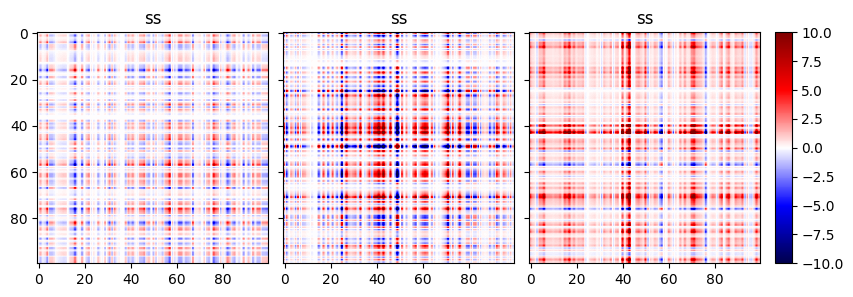

In [66]:
from mpl_toolkits.axes_grid1 import ImageGrid

# Set up figure and image grid
fig = plt.figure(figsize=(9.75, 3))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
for r, ax in enumerate(grid):
    rank_component = (model['column_factors'][:,r][:,None] @ model['column_factors'][:,r][None,:])
    # divide by norm of all 3 components
    im = ax.imshow(rank_component,cmap='seismic', vmax=10, vmin=-10)
    #ax.set_title('ss')

# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

In [75]:
# generate data for all intervals (4 trained, plus 4 shorter/longer)
new_intervals = jnp.array([[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]])
# middling cue time (but could change this)
measure_min = 15
measure_max = 16

new_inputs, new_outputs, new_masks = sample_all(110,
           new_intervals,
            measure_min,
            measure_max,
            15,)

x0 = jnp.ones((100,))*0.1
z0 = jnp.ones((5,))*0.1

ys, xs, zs = batched_nm_rnn(model, x0, z0, new_inputs, 10, 100)

In [77]:
xs.shape

(12, 110, 100)

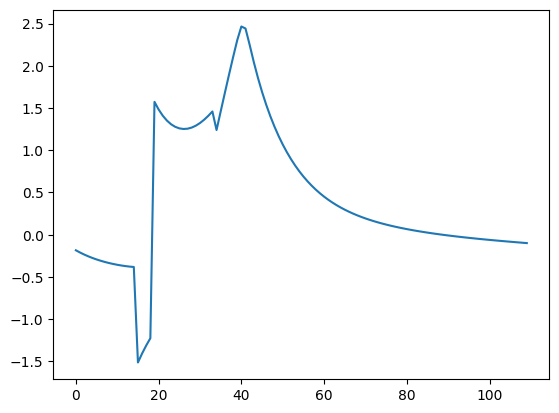

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
pca.fit(jnp.vstack(xs))

xs_pca = pca.transform(jnp.vstack(xs)).reshape((12,110,10))
plt.plot(xs_pca[0,:,3])

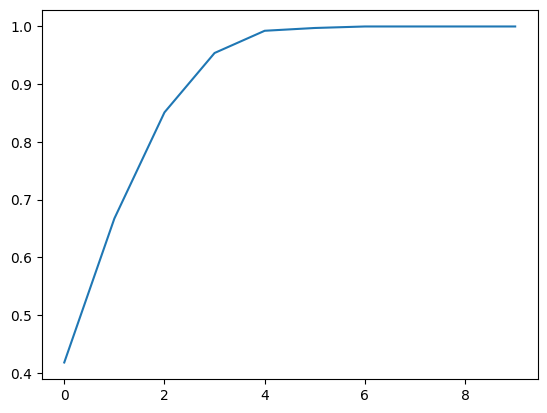

In [87]:
plt.plot(pca.explained_variance_ratio_.cumsum())

In [100]:
Q, R = jnp.linalg.qr(model['column_factors'])
jnp.dot(xs[0,:,:], Q)

Array([[-1.61036491e-01,  2.07657754e-01, -6.02605104e-01],
       [-1.55370310e-01,  2.06443191e-01, -5.98592699e-01],
       [-1.50143519e-01,  2.05360174e-01, -5.95078826e-01],
       [-1.45336986e-01,  2.04406068e-01, -5.91998279e-01],
       [-1.40928566e-01,  2.03581005e-01, -5.89293301e-01],
       [-1.36894345e-01,  2.02889428e-01, -5.86911917e-01],
       [-1.33209959e-01,  2.02342093e-01, -5.84808290e-01],
       [-1.29851237e-01,  2.01957986e-01, -5.82940102e-01],
       [-1.26794785e-01,  2.01767370e-01, -5.81269562e-01],
       [-1.24018669e-01,  2.01815367e-01, -5.79760313e-01],
       [-1.21502586e-01,  2.02165544e-01, -5.78377545e-01],
       [-1.19228147e-01,  2.02904746e-01, -5.77086568e-01],
       [-1.17179275e-01,  2.04146817e-01, -5.75851977e-01],
       [-1.15342177e-01,  2.06036538e-01, -5.74637890e-01],
       [-1.13705605e-01,  2.08750650e-01, -5.73406518e-01],
       [ 1.46990553e-01,  3.88458323e+00, -7.08466947e-01],
       [ 1.23028658e-01,  3.51529980e+00

In [105]:
recurrent_components = jnp.einsum('ctn,nr->ctr', xs, Q)
recurrent_components.shape

(12, 110, 3)

In [272]:
R

Array([[-10.929997 ,  -6.5405846,  -3.5650287],
       [  0.       ,  14.412867 ,  -4.844932 ],
       [  0.       ,   0.       ,  13.076394 ]], dtype=float32)

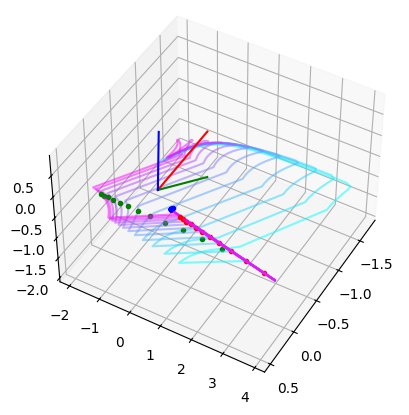

In [282]:
ax = plt.figure().add_subplot(projection='3d')

ax.prop_cycle = plt.cycler("color", plt.cm.cool(jnp.linspace(0,1,12)))

for i in range(12):
    ax.plot(recurrent_components[i,:,0], recurrent_components[i,:,1], recurrent_components[i,:,2],alpha=0.5)
    ax.plot(recurrent_components[i,10,0], recurrent_components[i,10,1], recurrent_components[i,10,2], '.', color='b')
    ax.plot(recurrent_components[i,10+new_intervals[0,i],0], recurrent_components[i,10+new_intervals[0,i],1], recurrent_components[i,10+new_intervals[0,i],2], '.', color='r')
    ax.plot(recurrent_components[i,25+new_intervals[0,i],0], recurrent_components[i,25+new_intervals[0,i],1], recurrent_components[i,25+new_intervals[0,i],2], '.', color='g')


ax.plot(recurrent_components[0,0,0], recurrent_components[0,0,1], recurrent_components[0,0,2], '.', color='b')
ax.plot((0, R[0,0]/jnp.linalg.norm(R[:,0])),(0, R[1,0]/jnp.linalg.norm(R[:,0])),(0,R[2,0]/jnp.linalg.norm(R[:,0])), color='r')
ax.plot((0, R[0,1]/jnp.linalg.norm(R[:,1])),(0, R[1,1]/jnp.linalg.norm(R[:,1])),(0,R[2,1]/jnp.linalg.norm(R[:,1])), color='g')
ax.plot((0, R[0,2]/jnp.linalg.norm(R[:,2])),(0, R[1,2]/jnp.linalg.norm(R[:,2])),(0,R[2,2]/jnp.linalg.norm(R[:,2])), color='b')

ax.view_init(45,30)

In [135]:
new_intervals[0,1]

Array(6, dtype=int32)

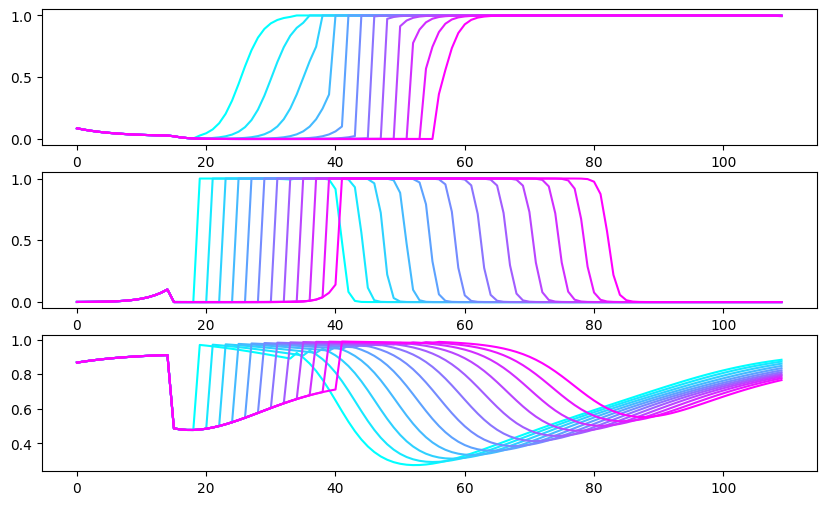

In [123]:
m = model['nm_sigmoid_weight']
b = model['nm_sigmoid_intercept']

fig, axes = plt.subplots(3, 1, figsize=[10,3*2])

for r, ax in enumerate(axes):
    for i in range(12):
        ax.plot(jax.nn.sigmoid((zs @ m.T + b)[i, :, r]))

In [127]:
new_outputs.shape

(12, 110, 1)

In [231]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(recurrent_components.reshape(-1, recurrent_components.shape[-1]), columns = ['k1', 'k2', 'k3'])
df['interval'] = jnp.repeat(new_intervals,110).astype(float)
colors = ['red']*4 + ['purple']*4 + ['blue']*4
fig = px.line_3d(df, x="k1", y="k2", z="k3", color="interval", color_discrete_sequence=colors)


fig.show()

/Users/costacurta/nm-rnn/nm_venv/lib/python3.9/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [288]:
import plotly.graph_objects as go

fig = go.Figure()

for i in range(12):
    x = recurrent_components[i,:,0]
    y = recurrent_components[i,:,1]
    z = recurrent_components[i,:,2]

    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                    mode='lines', line=dict(color=colors[i])))

    fig.add_trace(go.Scatter3d(x=[x[10]], y=[y[10]], z=[z[10]],
                        mode='markers', marker=dict(size=[10],color=['blue'])))

    fig.add_trace(go.Scatter3d(x=[x[10+new_intervals[0,i]]], y=[y[10+new_intervals[0,i]]], z=[z[10+new_intervals[0,i]]],
                        mode='markers', marker=dict(size=[10],color=['red'])))

    fig.add_trace(go.Scatter3d(x=[x[25+new_intervals[0,i]]], y=[y[25+new_intervals[0,i]]], z=[z[25+new_intervals[0,i]]],
                        mode='markers', marker=dict(size=[10],color=['green'])))

fig.add_trace(go.Scatter3d(x=(0, R[0,0]/jnp.linalg.norm(R[:,0])),y=(0, R[1,0]/jnp.linalg.norm(R[:,0])),z=(0,R[2,0]/jnp.linalg.norm(R[:,0])),
                                mode='lines'))

fig.add_trace(go.Scatter3d(x=(0, R[0,1]/jnp.linalg.norm(R[:,1])),y=(0, R[1,1]/jnp.linalg.norm(R[:,1])),z=(0,R[2,1]/jnp.linalg.norm(R[:,1])),
                                mode='lines'))

fig.add_trace(go.Scatter3d(x=(0, R[0,2]/jnp.linalg.norm(R[:,2])),y=(0, R[1,2]/jnp.linalg.norm(R[:,2])),z=(0,R[2,2]/jnp.linalg.norm(R[:,2])),
                                mode='lines'))

fig.show()

In [199]:
x.shape

(110,)

In [222]:
colors

['red',
 'red',
 'red',
 'red',
 'purple',
 'purple',
 'purple',
 'purple',
 'blue',
 'blue',
 'blue',
 'blue']

# Ablations

In [349]:
measure = jnp.where(new_inputs[6,:,0]>0)
measure

(Array([15], dtype=int32),)

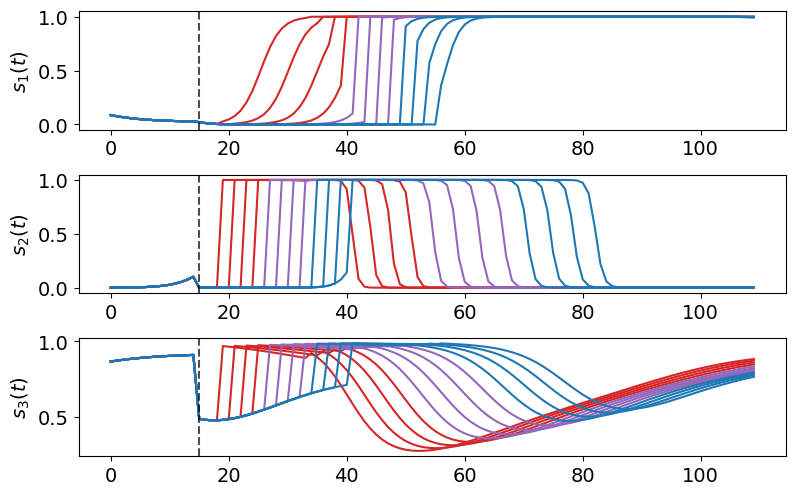

In [369]:
m = model['nm_sigmoid_weight']
b = model['nm_sigmoid_intercept']

fig, axes = plt.subplots(3, 1, figsize=[8,5])
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cool(jnp.linspace(0,1,N)))

colors = ['tab:red']*4 + ['tab:purple']*4 + ['tab:blue']*4
for r, ax in enumerate(axes):
    for i in range(12):
        ax.plot(jax.nn.sigmoid((zs @ m.T + b)[i, :, r]), color=colors[i])

axes[0].axvline(x=15, c='k', ls='--', alpha=0.7)
axes[1].axvline(x=15, c='k', ls='--', alpha=0.7)
axes[2].axvline(x=15, c='k', ls='--', alpha=0.7)
axes[0].set_ylabel("$s_1(t)$")
axes[1].set_ylabel("$s_2(t)$")
axes[2].set_ylabel("$s_3(t)$")
plt.tight_layout()
plt.savefig('align_0.pdf')

- first two components look like good ablation targets, if held at 0

In [249]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import grad, vmap, jit
from jax import lax
import optax

def nm_rnn_remove1(params, x0, z0, inputs, tau_x, tau_z, nln=jnp.tanh):
    """
    Arguments:
    - params
    - x0
    - inputs
    - tau   : decay constant
    """

    U = params["row_factors"]       # D x R
    V = params["column_factors"]    # D x R
    B_xu = params["input_weights"]     # D x M
    C = params["readout_weights"]   # O x D
    W_zz = params["nm_rec_weight"]         # dim_nm x dim_nm
    B_zu = params["nm_input_weight"]      # dim_nm x M
    m = params["nm_sigmoid_weight"]         # scalar
    c = params["nm_sigmoid_intercept"]      # scalar

    N = x0.shape[0]
    R = U.shape[1]

    def _step(x_and_z, u):
        x, z = x_and_z

        # update z
        z = (1.0 - (1. / tau_z)) * z + (1. / tau_z) * W_zz @ nln(z)
        z += (1. / tau_z) * B_zu @ u

        # update x
        xp = x # hold onto previous value
        s = jax.nn.sigmoid(m @ z + c) # calculate nm signal
        x = (1.0 - (1. / tau_x)) * xp # decay term
        h = V.T @ nln(xp)
        x += (1. / (tau_x * N)) * (U @ jnp.diag(jnp.array([0.0, s[1], s[2]]))) @ h  # divide by N
        x += (1. / tau_x) * B_xu @ u
        # x += (1. / (tau_x * N)) * (U @ jnp.diag(jnp.array([0.1, s[1], s[2]]))) @ h # divide by N

        # calculate y
        y = C @ x
        return (x, z), (y, x, z)

    _, (ys, xs, zs) = lax.scan(_step, (x0, z0), inputs)

    return ys, xs, zs

batched_nm_rnn_remove1 = vmap(nm_rnn_remove1, in_axes=(None, None, None, 0, None, None))

In [252]:
ys_nm3d_remove1, xs_remove1, _ = batched_nm_rnn_remove1(model, x0, z0, new_inputs, 10, 100)

Text(0.5, 1.0, 'activity when first NM signal is held constant')

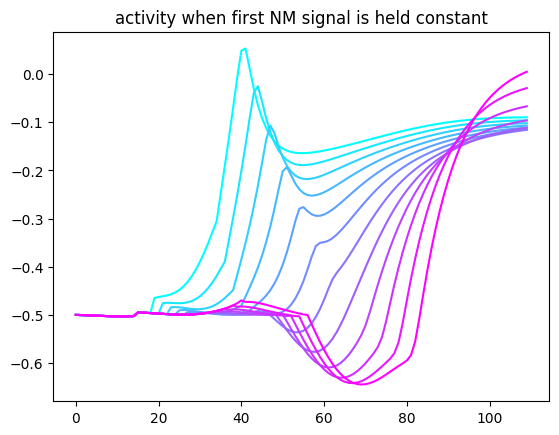

In [253]:
plt.plot(ys_nm3d_remove1[:,:,0].T)
plt.title('activity when first NM signal is held constant')

In [254]:
recurrent_components_remove1 = jnp.einsum('ctn,nr->ctr', xs_remove1, Q)


In [256]:
fig = go.Figure()

for i in range(12):
    x = recurrent_components_remove1[i,:,0]
    y = recurrent_components_remove1[i,:,1]
    z = recurrent_components_remove1[i,:,2]

    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                    mode='lines', line=dict(color=colors[i])))

    fig.add_trace(go.Scatter3d(x=[x[10]], y=[y[10]], z=[z[10]],
                        mode='markers', marker=dict(size=[10],color=['blue'])))

    fig.add_trace(go.Scatter3d(x=[x[10+new_intervals[0,i]]], y=[y[10+new_intervals[0,i]]], z=[z[10+new_intervals[0,i]]],
                        mode='markers', marker=dict(size=[10],color=['red'])))

    fig.add_trace(go.Scatter3d(x=[x[25+new_intervals[0,i]]], y=[y[25+new_intervals[0,i]]], z=[z[25+new_intervals[0,i]]],
                        mode='markers', marker=dict(size=[10],color=['green'])))

fig.show()

In [271]:
def nm_rnn_remove2(params, x0, z0, inputs, tau_x, tau_z, nln=jnp.tanh):
    """
    Arguments:
    - params
    - x0
    - inputs
    - tau   : decay constant
    """

    U = params["row_factors"]       # D x R
    V = params["column_factors"]    # D x R
    B_xu = params["input_weights"]     # D x M
    C = params["readout_weights"]   # O x D
    W_zz = params["nm_rec_weight"]         # dim_nm x dim_nm
    B_zu = params["nm_input_weight"]      # dim_nm x M
    m = params["nm_sigmoid_weight"]         # scalar
    c = params["nm_sigmoid_intercept"]      # scalar

    N = x0.shape[0]
    R = U.shape[1]

    def _step(x_and_z, u):
        x, z = x_and_z

        # update z
        z = (1.0 - (1. / tau_z)) * z + (1. / tau_z) * W_zz @ nln(z)
        z += (1. / tau_z) * B_zu @ u

        # update x
        xp = x # hold onto previous value
        s = jax.nn.sigmoid(m @ z + c) # calculate nm signal
        x = (1.0 - (1. / tau_x)) * xp # decay term
        h = V.T @ nln(xp)
        x += (1. / (tau_x * N)) * (U @ jnp.diag(jnp.array([s[0], 0.0, s[2]]))) @ h  # divide by N
        x += (1. / tau_x) * B_xu @ u
        # x += (1. / (tau_x * N)) * (U @ jnp.diag(jnp.array([0.1, s[1], s[2]]))) @ h # divide by N

        # calculate y
        y = C @ x
        return (x, z), (y, x, z)

    _, (ys, xs, zs) = lax.scan(_step, (x0, z0), inputs)

    return ys, xs, zs

batched_nm_rnn_remove2 = vmap(nm_rnn_remove2, in_axes=(None, None, None, 0, None, None))

In [264]:
ys_nm3d_remove2, xs_remove2, _ = batched_nm_rnn_remove2(model, x0, z0, new_inputs, 10, 100)

Text(0.5, 1.0, 'activity when second NM signal is held constant')

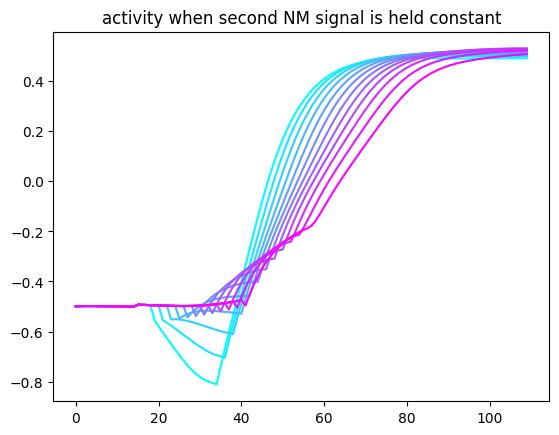

In [265]:
plt.plot(ys_nm3d_remove2[:,:,0].T)
plt.title('activity when second NM signal is held constant')

In [269]:
recurrent_components_remove2 = jnp.einsum('ctn,nr->ctr', xs_remove2, Q)

In [270]:
fig = go.Figure()

for i in range(12):
    x = recurrent_components_remove2[i,:,0]
    y = recurrent_components_remove2[i,:,1]
    z = recurrent_components_remove2[i,:,2]

    fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                                    mode='lines', line=dict(color=colors[i])))

    fig.add_trace(go.Scatter3d(x=[x[10]], y=[y[10]], z=[z[10]],
                        mode='markers', marker=dict(size=[10],color=['blue'])))

    fig.add_trace(go.Scatter3d(x=[x[10+new_intervals[0,i]]], y=[y[10+new_intervals[0,i]]], z=[z[10+new_intervals[0,i]]],
                        mode='markers', marker=dict(size=[10],color=['red'])))

    fig.add_trace(go.Scatter3d(x=[x[25+new_intervals[0,i]]], y=[y[25+new_intervals[0,i]]], z=[z[25+new_intervals[0,i]]],
                        mode='markers', marker=dict(size=[10],color=['green'])))

fig.show()

In [290]:
with open('lr_rnn_150k_12_14_16_18.pkl', 'rb') as f:
    lr_params = pickle.load(f)

In [342]:
from nmrnn.rnn_code import batched_nm_rnn, batched_lr_rnn

new_intervals = jnp.array([[4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]])
measure_min = 15
measure_max = 16
delay = 15
mask_pad = 3
T = 110

N = 100
M = 5

# Hyperparameters
tau_x = 10
x0 = jnp.ones((N,))*0.1
tau_z = 100
z0 = jnp.ones((M,))*0.1

new_inputs, new_outputs, new_masks = sample_all(T,
           new_intervals,
            measure_min,
            measure_max,
            delay,
            mask_pad,)

lr_inputs = jnp.concatenate((new_inputs, jnp.zeros((new_intervals.shape[1],110, 1))), axis=2)

ys_nm3d, xs_nm3d, zs_nm3d = batched_nm_rnn(model, x0, z0, new_inputs, tau_x, tau_z)
ys_lr, xs_lr = batched_lr_rnn(lr_params, 10*x0, lr_inputs, tau_x)

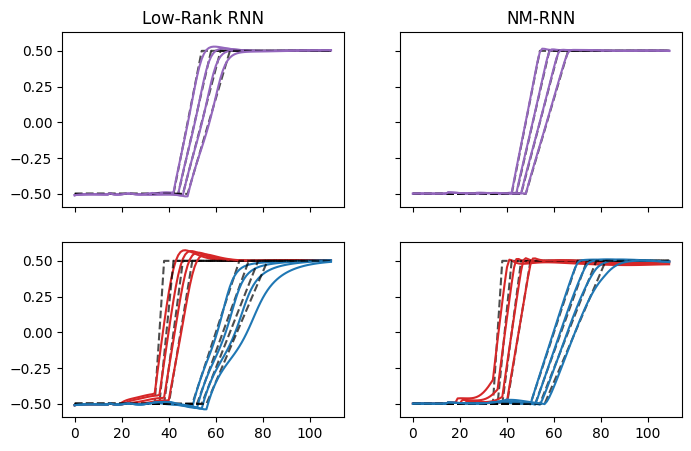

In [343]:
N = new_intervals.shape[1]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.brg(jnp.linspace(0,1,N)))

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8, 5), sharey=True, sharex=True)
for i in [4, 5, 6, 7]:
    ax1[0].plot(new_outputs[i], 'k--', alpha=0.7)
    ax1[0].plot(ys_lr[i], c='tab:purple')
    ax1[0].set_title('Low-Rank RNN')
    ax1[1].plot(new_outputs[i], 'k--', alpha=0.7)
    ax1[1].plot(ys_nm3d[i], c='tab:purple')
    ax1[1].set_title('NM-RNN')

for i in [0, 1, 2, 3]:
    ax2[0].plot(new_outputs[i], 'k--', alpha=0.7)
    ax2[0].plot(ys_lr[i], c='tab:red')
    ax2[1].plot(new_outputs[i], 'k--', alpha=0.7)
    ax2[1].plot(ys_nm3d[i], c='tab:red')
    # ax2[2].set_title('3D NM-RNN')


for i in [8,9,10,11]:
    ax2[0].plot(new_outputs[i], 'k--', alpha=0.7)
    ax2[0].plot(ys_lr[i], c='tab:blue')
    ax2[1].plot(new_outputs[i], 'k--', alpha=0.7)
    ax2[1].plot(ys_nm3d[i], c='tab:blue')
    # ax2[2].set_title('3D NM-RNN')

plt.savefig('performance_comparison.pdf')
plt.show()


In [344]:
go_cue = new_inputs[:,:,2]
go_ind = jnp.where(go_cue)[1]

In [345]:
nm3d_90 = jnp.zeros(N)
# first_dim, second_dim, _ = jnp.where(ys_nm3d>=0.4)
for i in range(N):
    max_val_90 = 0.9*jnp.max(ys_nm3d[i])
    cross_90 = jnp.min((jnp.where(ys_nm3d[i] > max_val_90))[0])
    nm3d_90 = nm3d_90.at[i].set((cross_90-go_ind[i]))

nm3d_90

Array([ 7.,  8.,  9., 10., 12., 14., 16., 18., 20., 22., 25., 29.],      dtype=float32)

In [346]:
lr_90 = jnp.zeros(N)
# first_dim, second_dim, _ = jnp.where(ys_nm3d>=0.4)
for i in range(N):
    max_val_90 = 0.9*jnp.max(ys_lr[i])
    cross_90 = jnp.min((jnp.where(ys_lr[i] > max_val_90))[0])
    lr_90 = lr_90.at[i].set((cross_90-go_ind[i]))

lr_90

Array([10., 10., 11., 12., 13., 15., 16., 19., 22., 26., 31., 38.],      dtype=float32)

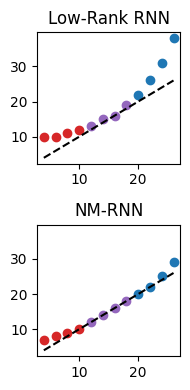

In [355]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(2,4), sharey=True)

ax1.plot(new_intervals.T, new_intervals.T, 'k--')
ax2.plot(new_intervals.T, new_intervals.T, 'k--')

ax1.scatter(new_intervals[0,:4], lr_90[:4], c='tab:red')
ax1.scatter(new_intervals[0,4:8], lr_90[4:8], c='tab:purple')
ax1.scatter(new_intervals[0,8:], lr_90[8:], c='tab:blue')
ax1.set_title('Low-Rank RNN')

ax2.scatter(new_intervals[0,:4], nm3d_90[:4], c='tab:red')
ax2.scatter(new_intervals[0,4:8], nm3d_90[4:8], c='tab:purple')
ax2.scatter(new_intervals[0,8:], nm3d_90[8:], c='tab:blue')
ax2.set_title('NM-RNN')
# ax3.scatter(new_intervals, nm3d_intervals, c='r')
plt.tight_layout()
plt.savefig('approx_intervals.pdf')

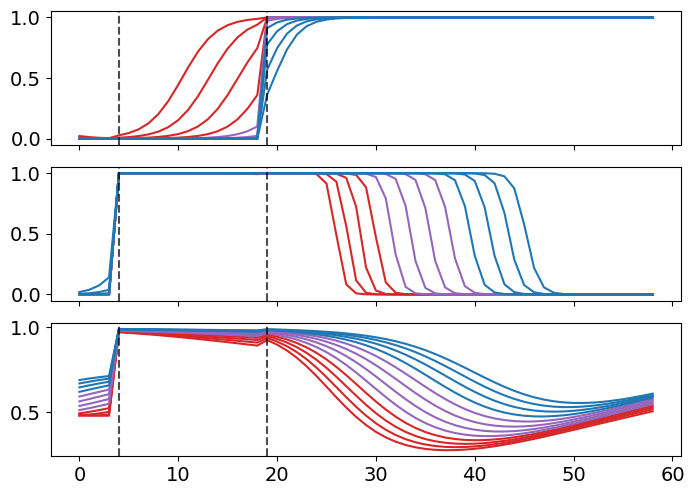

In [370]:
m_3d = model['nm_sigmoid_weight']
b_3d = model['nm_sigmoid_intercept']
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.cool(jnp.linspace(0,1,N)))

go_cues = jnp.where(new_inputs[:,:,2])[1]
go_mask = jnp.zeros((12, 110), dtype=bool)
ind_range = jnp.arange(110)

colors = ['tab:red']*4 + ['tab:purple']*4 + ['tab:blue']*4

for i in range(12):
    go_mask = go_mask.at[i].set((ind_range > go_cues[i] - 20) * (ind_range < go_cues[i] + 40))

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=[7,5], sharex=True)
# ax0.xlabel('Timestep')
for i in range(12):
    ax0.plot(jax.nn.sigmoid((zs_nm3d @ m_3d.T + b_3d)[i,:,0])[go_mask[i]], color=colors[i])

for i in range(12):
    ax1.plot(jax.nn.sigmoid((zs_nm3d @ m_3d.T + b_3d)[i,:,1])[go_mask[i]], color=colors[i])

for i in range(12):
    ax2.plot(jax.nn.sigmoid((zs_nm3d @ m_3d.T + b_3d)[i,:,2])[go_mask[i]], color=colors[i])


ax0.axvline(x=4, c='k', ls='--', alpha=0.7)
ax0.axvline(x=19, c='k', ls='--', alpha=0.7)
ax1.axvline(x=4, c='k', ls='--', alpha=0.7)
ax1.axvline(x=19, c='k', ls='--', alpha=0.7)
ax2.axvline(x=4, c='k', ls='--', alpha=0.7)
ax2.axvline(x=19, c='k', ls='--', alpha=0.7)
plt.tight_layout()
plt.savefig('align_go.pdf')

In [363]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title